# Natural Language Processing with Disaster Tweets

## Kaggle Project: 
Link: https://www.kaggle.com/c/nlp-getting-started/overview

## Overview: 
In this competition, the task is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. The columns for the training and test datasets are:

- `id` a unique identifier for each tweet
- `text` the text of the tweet
- `location` the location the tweet was sent from (may be blank)
- `keyword` a particular keyword from the tweet (may be blank)
- `target` in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

The selected models were a TF-IDF Vectorizer utilizing Logistic Regression and three different Recurrent Neural Networks (RNN) that use Bidirectional Long Short-Term Memory (LSTM) units. The first RNN model is utilized as a baseline model whereas the following two models represent some hyperparameter tuning. 

### Import Libraries: 
The necessary libraries needed for this project are imported below. 

In [1]:
# Math functions and plotting:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn for TfidVectorizer, train-test-split, and several metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# For text preprocessing; utilizing PorterStemmer to reduce words to root form
import re
import nltk 
from nltk.stem import PorterStemmer

# Tensorflow for tokenizing, padding, optimizing, regularizing, and for RNN 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

### Load the Data and Exploratory Data Analysis (EDA):
Gather basic information regarding the dataframes and provide a histogram to understand the distribution of the target labels. 

In [2]:
# Create dataframes for the test and training data
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

In [3]:
# Examine first 5 columns of the test data
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
# Examine the shape of the test data
test_df.shape

(3263, 4)

In [5]:
# Examine first 5 columns of the train data
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Examine the shape of the train data
train_df.shape

(7613, 5)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

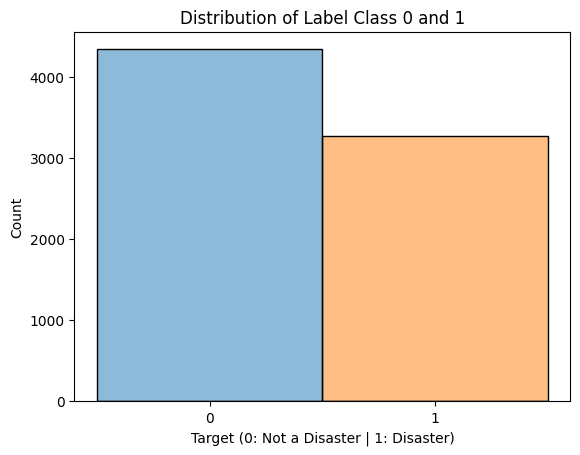

In [7]:
# Plot the distribution of the Target Classes for 0 and 1
sns.histplot(data=train_df, 
             x="target", 
             hue="target", 
             legend=False, 
             discrete=True, 
             binwidth=0.6)
plt.xticks([0,1])
plt.xlabel("Target (0: Not a Disaster | 1: Disaster)")
plt.title("Distribution of Label Class 0 and 1")
plt.show()

In [8]:
# Create the PorterStemmer for the language processing
stemmer = PorterStemmer()

# Create a preprocessing function that lowercases each letter, removes punctuation,
# and applies the PorterStemmer. The # was kept as it would like indicate significance
# in the model since twitter is known for hastagging
def text_preprocesser(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  
    text = ' '.join([stemmer.stem(word) for word in text.split()]) 
    return text

# Utilize the text_preprocessor on the train and test data
train_df['text'] = train_df['text'].apply(text_preprocesser)
test_df['text'] = test_df['text'].apply(text_preprocesser)

In [9]:
# Investigate the first 5 columns of the test data to confirm text_preprocessor works
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,just happen a terribl car crash
1,2,NaN,NaN,heard about earthquak is differ citi stay safe...
2,3,NaN,NaN,there is a forest fire at spot pond gees are f...
3,9,NaN,NaN,apocalyps light spokan wildfir
4,11,NaN,NaN,typhoon soudelor kill 28 in china and taiwan


In [10]:
# Investigate the first 5 columns of the train data to confirm text_preprocessor works
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deed are the reason of thi earthquak may a...,1
1,4,NaN,NaN,forest fire near la rong sask canada,1
2,5,NaN,NaN,all resid ask to shelter in place are be notif...,1
3,6,NaN,NaN,13000 peopl receiv wildfir evacu order in cali...,1
4,7,NaN,NaN,just got sent thi photo from rubi alaska as sm...,1


In [11]:
# Train, test, split on the train data
X = train_df['text']
y = train_df['target']
X_train, X_val, y_train, y_val = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42
                                                 )

## TF-IDF Vectorization and Logistic Regression:
Utilizing the TF-IDF (Term Frequence-Inverted Document Frequency) Vectorization to convert the text data into numerical features and a logistic regression model, we can gather a baseline prediction to later compare to our RNN models. 

In [12]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, stop_words='english')),
    ('clf', LogisticRegression())
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=1000, stop_words='english')),
                ('clf', LogisticRegression())])

In [13]:
# Print the results (precision, recall, f1, accuracy)
y_val_pred = pipeline.predict(X_val)

print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       874
           1       0.80      0.70      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



# First RNN Model Utilizing LSTM
Before the model was operated, the textual data was further preprocessed by tokenization and padding. The breakdown of the first RNN Model Utilizing LSTM is detailed below:

**Input:**
- `vocab_size`: 20,000 most frequent units stored in the vocabulary. The Out Of Vocabulary (OOV) are placed with a special key in the tokenizer. 
- `max_length`: 100 tokens for input that are padded or truncated.

**Architecture:**
- Embedding Layer
    - `embedding_dim` set to 128
- First Bidirectional LSTM Layer
    - 128 LSTM units utilizing bidirectional processing
- Dropout Layer
    - Dropout rate set to 0.3
- Second Bidirectional LSTM Layer
    - 64 LSTM units utilizing bidirectional processing
- Dropout Layer
    - Dropout rate set to 0.3
- Fully Connected Dense Layer
    - 64 neurons utilizing ReLU activation.
- Ouput Layer
    - 1 neuron utilizing sigmoid activation.
- Optimizer:
    - Adam with default learning rate
- Loss Function:
    - Binary Crossentropy
- Metrics:
    - Accuracy 

In [14]:
# Input information for the tokenizer and padding
vocab_size = 20000
max_length = 100
embedding_dim = 128
dropout_rate = 0.3

# Create tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])

# Apply the tokenizer
X_train_seq = tokenizer.texts_to_sequences(train_df['text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['text'])

# Apply the padding
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

y_train = train_df['target'].values

# Check the shapes
print("X_train_padded shape:", X_train_padded.shape)
print("X_test_padded shape:", X_test_padded.shape)
print("y_train shape:", y_train.shape)

X_train_padded shape: (7613, 100)
X_test_padded shape: (3263, 100)
y_train shape: (7613,)


In [15]:
# Define the Model1
model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(dropout_rate),
    Bidirectional(LSTM(64)),
    Dropout(dropout_rate),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Build the Model1
model1.build(input_shape=(None, max_length))  # None for batch size, max_length for sequence length

# Print the Model1 summary
model1.summary()

# Apply the loss function, the optimizer, and the metrics to Model1
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,995,841 (11.43 MB)

 Trainable params: 2,995,841 (11.43 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Fit the Model1
history = model1.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 411ms/step - accuracy: 0.6480 - loss: 0.6141 - val_accuracy: 0.7853 - val_loss: 0.4602
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 377ms/step - accuracy: 0.8866 - loss: 0.2929 - val_accuracy: 0.7768 - val_loss: 0.5109
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 378ms/step - accuracy: 0.9294 - loss: 0.2059 - val_accuracy: 0.7682 - val_loss: 0.5863
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 378ms/step - accuracy: 0.9621 - loss: 0.1076 - val_accuracy: 0.7367 - val_loss: 0.7194
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 402ms/step - accuracy: 0.9819 - loss: 0.0559 - val_accuracy: 0.7163 - val_loss: 0.9087
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 376ms/step - accuracy: 0.9924 - loss: 0.0287 - val_accuracy: 0.7170 - val_loss: 0.8659
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 377ms/step - accuracy: 0.9897 - loss: 0.0271 - val_accuracy: 0.7183 - val_loss: 1.1316
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 378ms/step - accuracy: 0.9942 - loss: 0.0182 - val_accu

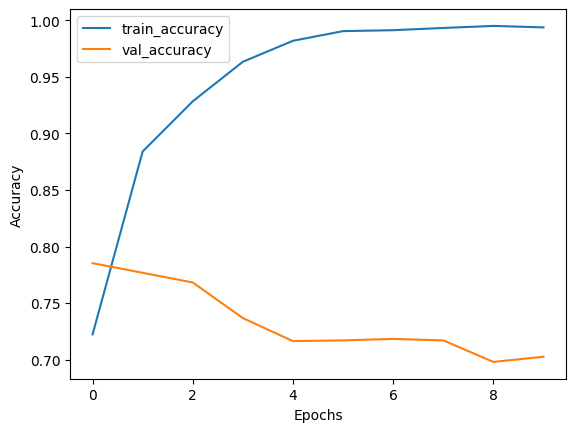

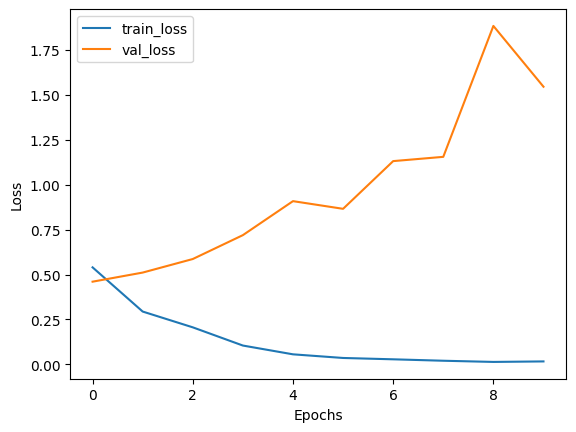

In [17]:
# Plot accuracy for the Model1
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss for the Model1
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Second RNN Model Utilizing LSTM
The model architecture for the Second RNN Model Utilizing LSTM is identical to the First RNN Model Utilizing LSTM with the following hyperparameter adjustments: 

- The dropout rate present in both layers was increased from 0.3 to 0.5
- The vocabulary size was reduced from 20000 to 10000
- An L2 Regularization was added (set to 0.02)

Each of these steps were in an effort to try and reduce overfitting. 

In [18]:
# Input information for the tokenizer and padding
max_length2 = 100
embedding_dim2 = 128
vocab_size2 = 10000
dropout_rate2 = 0.5

# Create tokenizer
tokenizer2 = Tokenizer(num_words=vocab_size2, oov_token="<OOV>")
tokenizer2.fit_on_texts(train_df['text'])

# Apply the tokenizer
X_train_seq2 = tokenizer2.texts_to_sequences(train_df['text'])
X_test_seq2 = tokenizer2.texts_to_sequences(test_df['text'])

# Apply the padding
X_train_padded2 = pad_sequences(X_train_seq2, maxlen=max_length2, padding='post', truncating='post')
X_test_padded2 = pad_sequences(X_test_seq2, maxlen=max_length2, padding='post', truncating='post')

# Check the shapes
print("X_train_padded shape:", X_train_padded2.shape)
print("X_test_padded shape:", X_test_padded2.shape)
print("y_train shape:", y_train.shape)

# Define the Model2
model2 = Sequential([
    Embedding(input_dim=vocab_size2, output_dim=embedding_dim2, input_length=max_length2),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(dropout_rate2),
    Bidirectional(LSTM(64)),
    Dropout(dropout_rate2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.02)),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Build the Model2
model2.build(input_shape=(None, max_length))  # None for batch size, max_length for sequence length

# Print the Model2 summary
model2.summary()

# Apply the loss function, the optimizer, and the metrics to the Model2
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train_padded shape: (7613, 100)
X_test_padded shape: (3263, 100)
y_train shape: (7613,)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,715,841 (6.55 MB)

 Trainable params: 1,715,841 (6.55 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Fit the Model2
history2 = model2.fit(X_train_padded2, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 403ms/step - accuracy: 0.6208 - loss: 1.8317 - val_accuracy: 0.7735 - val_loss: 0.7968
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.8621 - loss: 0.5685 - val_accuracy: 0.7991 - val_loss: 0.5289
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 372ms/step - accuracy: 0.9191 - loss: 0.2847 - val_accuracy: 0.7741 - val_loss: 0.5732
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 370ms/step - accuracy: 0.9386 - loss: 0.2048 - val_accuracy: 0.7466 - val_loss: 0.7006
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - accuracy: 0.9541 - loss: 0.1642 - val_accuracy: 0.7643 - val_loss: 0.7186
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9678 - loss: 0.1234 - val_accuracy: 0.7269 - val_loss: 0.7430
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 371ms/step - accuracy: 0.9655 - loss: 0.1169 - val_accuracy: 0.7518 - val_loss: 0.9438
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9732 - loss: 0.0830 - val_accu

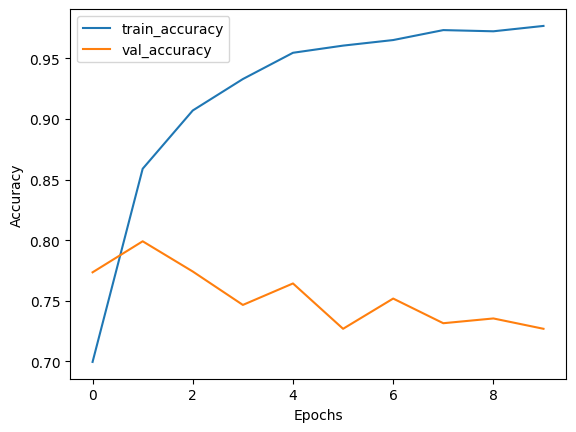

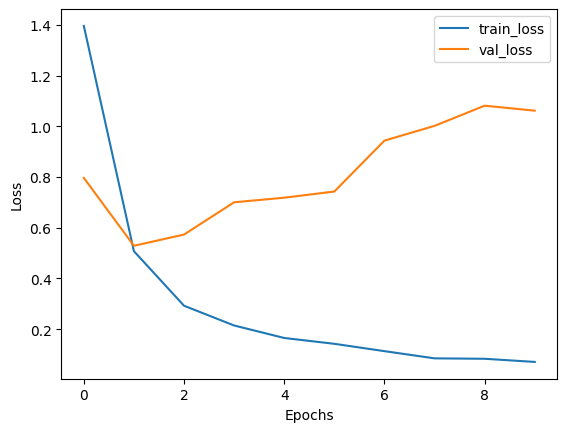

In [20]:
# Plot accuracy for Model2
plt.plot(history2.history['accuracy'], label='train_accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss for Model2
plt.plot(history2.history['loss'], label='train_loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Third RNN Model Utilizing LSTM
The model architecture for the Third RNN Model Utilizing LSTM is identical to the Second RNN Model Utilizing LSTM with the following hyperparameter adjustments: 

- The learning rate was reduced from the default value (0.001) to 0.0001.
- L2 Regularization increased from 0.02 to 0.03. 

In [21]:
# Input information for the tokenizer and padding
max_length3 = 100
embedding_dim3 = 128
vocab_size3 = 10000
dropout_rate3 = 0.5

# Create the tokenizer
tokenizer3 = Tokenizer(num_words=vocab_size3, oov_token="<OOV>")
tokenizer3.fit_on_texts(train_df['text'])

# Apply the tokenizer
X_train_seq3 = tokenizer3.texts_to_sequences(train_df['text'])
X_test_seq3 = tokenizer3.texts_to_sequences(test_df['text'])

# Apply the padding
X_train_padded3 = pad_sequences(X_train_seq3, maxlen=max_length3, padding='post', truncating='post')
X_test_padded3 = pad_sequences(X_test_seq3, maxlen=max_length3, padding='post', truncating='post')

# Check the shapes
print("X_train_padded shape:", X_train_padded3.shape)
print("X_test_padded shape:", X_test_padded3.shape)
print("y_train shape:", y_train.shape)

# Define Model3
model3 = Sequential([
    Embedding(input_dim=vocab_size3, output_dim=embedding_dim3, input_length=max_length3),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(dropout_rate3),
    Bidirectional(LSTM(64)),
    Dropout(dropout_rate3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.03)),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Build the Model3
model3.build(input_shape=(None, max_length))  # None for batch size, max_length for sequence length

# Print the Model3 summary
model3.summary()

# Apply the loss function, optimizer, and metrics to Model3
model3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

X_train_padded shape: (7613, 100)
X_test_padded shape: (3263, 100)
y_train shape: (7613,)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 100, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,715,841 (6.55 MB)

 Trainable params: 1,715,841 (6.55 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history3 = model3.fit(X_train_padded3, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 376ms/step - accuracy: 0.5457 - loss: 3.1520 - val_accuracy: 0.5345 - val_loss: 2.8676
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.5744 - loss: 2.7682 - val_accuracy: 0.5345 - val_loss: 2.5229
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.6739 - loss: 2.3830 - val_accuracy: 0.7748 - val_loss: 2.0865
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.8401 - loss: 1.9249 - val_accuracy: 0.7741 - val_loss: 1.8257
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 370ms/step - accuracy: 0.8781 - loss: 1.6281 - val_accuracy: 0.7551 - val_loss: 1.6803
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 35s 367ms/step - accuracy: 0.8999 - loss: 1.3809 - val_accuracy: 0.7945 - val_loss: 1.4806
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 35s 367ms/step - accuracy: 0.9199 - loss: 1.1769 - val_accuracy: 0.7768 - val_loss: 1.3955
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.9180 - loss: 1.0283 - val_accu

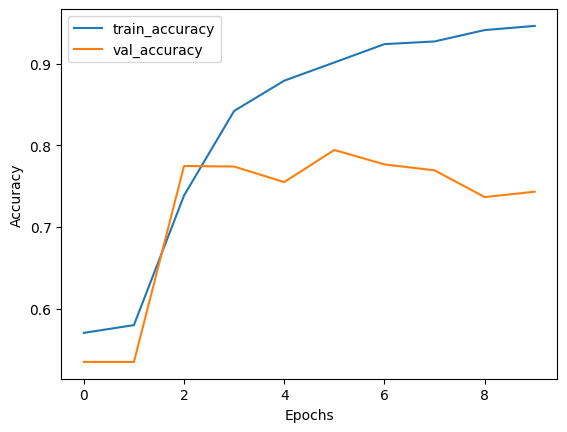

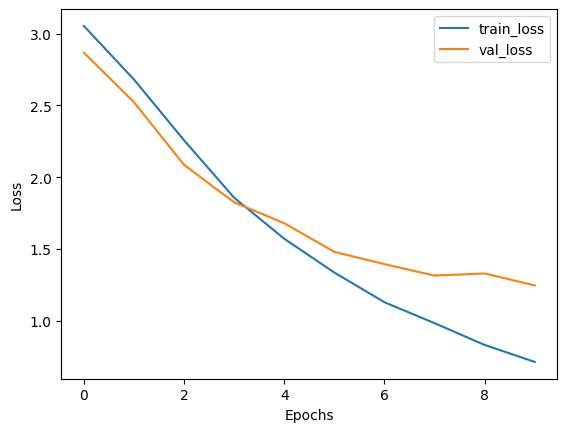

In [23]:
# Plot accuracy
plt.plot(history3.history['accuracy'], label='train_accuracy')
plt.plot(history3.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history3.history['loss'], label='train_loss')
plt.plot(history3.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation 
The Accuracy, F1 Score, Recall, and Precision were all calculated for each of the RNN models to compare overall performance. The confusion matrices for each model predictions were also developed. 

In [24]:
# Tokenize the validation set
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')

X_val_seq2 = tokenizer2.texts_to_sequences(X_val)
X_val_padded2 = pad_sequences(X_val_seq2, maxlen=max_length2, padding='post', truncating='post')

X_val_seq3 = tokenizer3.texts_to_sequences(X_val)
X_val_padded3 = pad_sequences(X_val_seq3, maxlen=max_length3, padding='post', truncating='post')


In [25]:
# Generate predictions for each model
predictions_model1 = (model1.predict(X_val_padded) > 0.5).astype(int)
predictions_model2 = (model2.predict(X_val_padded2) > 0.5).astype(int)
predictions_model3 = (model3.predict(X_val_padded3) > 0.5).astype(int)

# Compute precision, recall, and F1-score for each model
precision1 = precision_score(y_val, predictions_model1)
recall1 = recall_score(y_val, predictions_model1)
f1_1 = f1_score(y_val, predictions_model1)
accuracy1 = accuracy_score(y_val, predictions_model1)

precision2 = precision_score(y_val, predictions_model2)
recall2 = recall_score(y_val, predictions_model2)
f1_2 = f1_score(y_val, predictions_model2)
accuracy2 = accuracy_score(y_val, predictions_model2)

precision3 = precision_score(y_val, predictions_model3)
recall3 = recall_score(y_val, predictions_model3)
f1_3 = f1_score(y_val, predictions_model3)
accuracy3 = accuracy_score(y_val, predictions_model3)

# Print the metrics for all models
print("Model Metrics:")
print(f"Model 1 - Accuracy: {accuracy1:.4f}, Precision: {precision1:.4f}, Recall: {recall1:.4f}, F1-Score: {f1_1:.4f}")
print(f"Model 2 - Accuracy: {accuracy2:.4f}, Precision: {precision2:.4f}, Recall: {recall2:.4f}, F1-Score: {f1_2:.4f}")
print(f"Model 3 - Accuracy: {accuracy3:.4f}, Precision: {precision3:.4f}, Recall: {recall3:.4f}, F1-Score: {f1_3:.4f}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step
Model Metrics:
Model 1 - Accuracy: 0.9278, Precision: 0.9178, Recall: 0.9122, F1-Score: 0.9150
Model 2 - Accuracy: 0.9251, Precision: 0.9407, Recall: 0.8798, F1-Score: 0.9092
Model 3 - Accuracy: 0.9054, Precision: 0.8915, Recall: 0.8860, F1-Score: 0.8887


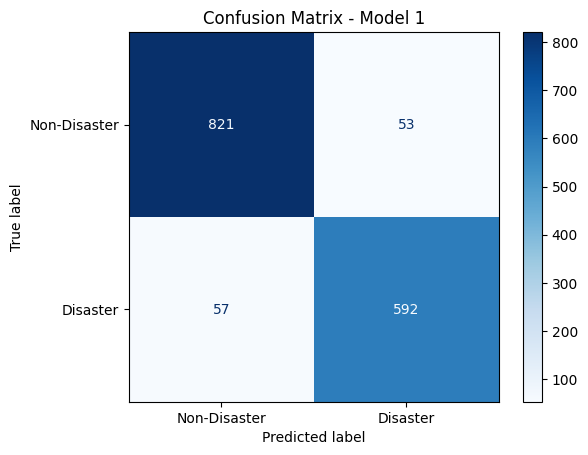

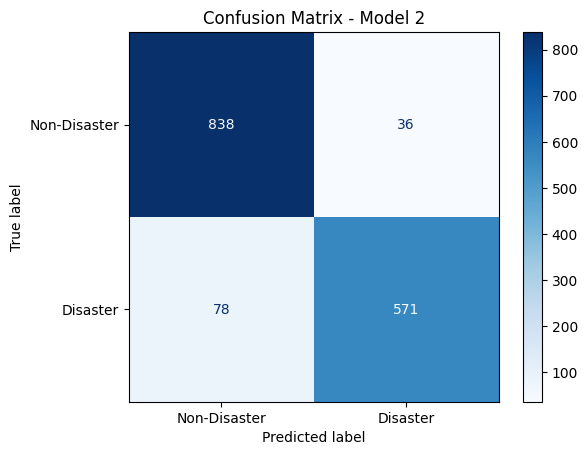

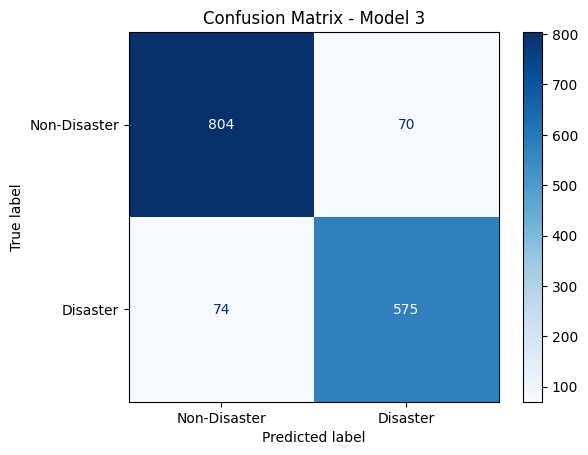

In [26]:
# Confusion matrix for Model 1
cm1 = confusion_matrix(y_val, predictions_model1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=["Non-Disaster", "Disaster"])
disp1.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Model 1")
plt.show()

# Confusion matrix for Model 2
cm2 = confusion_matrix(y_val, predictions_model2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["Non-Disaster", "Disaster"])
disp2.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Model 2")
plt.show()

# Confusion matrix for Model 3
cm3 = confusion_matrix(y_val, predictions_model3)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=["Non-Disaster", "Disaster"])
disp3.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Model 3")
plt.show()

In [27]:
# Create the submission DataFrame
test_predictions = (model2.predict(X_test_padded2) > 0.5).astype(int)

submission = pd.DataFrame({
    "id": test_df["id"],  # Use the 'id' column from the test dataset
    "target": test_predictions.flatten()  # Flatten predictions to match shape
})

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step


In [28]:
# Create the submission csv
submission.to_csv("submission.csv", index=False)

print("Submission file created successfully!")

Submission file created successfully!


# Conclusions:
The model metrics for the three RNN models are detailed below (when first ran):

- Model 1 - Accuracy: 0.9304, Precision: 0.9022, Recall: 0.9384, F1-Score: 0.9199
- Model 2 - Accuracy: 0.9173, Precision: 0.9252, Recall: 0.8767, F1-Score: 0.9003
- Model 3 - Accuracy: 0.9074, Precision: 0.9164, Recall: 0.8613, F1-Score: 0.8880

Based on these results the Model 1 had the best accuracy, recall, and F1-score, whereas Model 2 had the best precision and had the second highest metrics in every other category. Based off the plots for the Accuracy vs. Epochs and the Loss vs. Epochs, Model 1 severly overfits the data; therefore, Model 2 is a better overall selection. While Model 3 addresses the overfitting even more, Model 2 seems to provide a good balance of both performance and fit. 

The results from the TF-IDF Vectorization and Logistic Regression model were not as accurate as the RNN models based on the results above. 

Next steps could include further tuning of hyperparameters, such as adding Batch Normalization, tuning the learning rate, L2 Regularization factor, and other features in the layers of the model. 